Importing the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

In [3]:
import xgboost as xgb

# Dataset Preparation

Loading the dataset:

In [4]:
df = pd.read_csv("../homework 1/raw.githubusercontent.com_alexeygrigorev_datasets_master_housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Extracting the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`:

In [5]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df['ocean_proximity'].unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

Filling missing values with zeros:

In [6]:
df = df.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Splitting the dataset into train/validation/test with 60%/20%/20% distribution:

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

Resetting index values:

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Log-transforming the target variable:

In [9]:
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

Deleting the target variable data from the feature dataframes:

In [10]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

Transforming feature dataframes into matrices:

In [11]:
dv = DictVectorizer(sparse=True)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Question 1

Training a decision stump:

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Plotting the decision stump:

[Text(0.5, 0.75, 'ocean_proximity=<1H OCEAN <= 0.5\nsquared_error = 0.322\nsamples = 9411\nvalue = 12.011'),
 Text(0.25, 0.25, 'squared_error = 0.23\nsamples = 3924\nvalue = 11.607'),
 Text(0.75, 0.25, 'squared_error = 0.186\nsamples = 5487\nvalue = 12.301')]

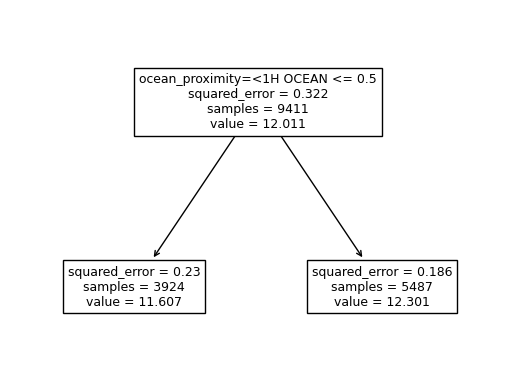

In [13]:
plot_tree(dt, feature_names=list(dv.get_feature_names_out()))

As seen from above plot, the feature used for splitting the data is `ocean_proximity`.

# Question 2

Training a random forest model with the specified parameters:

In [14]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

Calculating the RMSE of this model:

In [16]:
y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
rmse

0.24527740463893763

Thus, the RMSE is 0.245.

# Question 3

Evaluating the random forest model with different number of decision trees:

In [47]:
rmse_table = pd.DataFrame(columns=['rmse'])

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    
    rmse_table.loc[n] = rmse

Plotting the collected RMSE values:

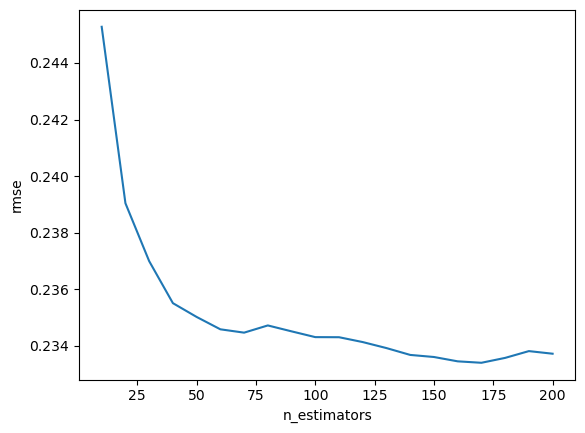

In [48]:
plt.plot(rmse_table)
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.show()

Displaying the RMSE values:

In [49]:
rmse_table.round(3)

,rmse
10,0.245
20,0.239
30,0.237
40,0.236
50,0.235
60,0.235
70,0.234
80,0.235
90,0.235
100,0.234


As seen from the table, RMSE stops substantially improving after the number of decision trees reaches around 50.

# Question 4

Tuning the maximum tree depth parameter. Evaluating the model with different number of trees at each `max_depth` value and recording the RMSE for each case into a dataframe:

In [44]:
max_depth_rmse_table = pd.DataFrame()

for max_depth in [10, 15, 20, 25]:
    rmse_series = pd.Series()
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        rmse_series.loc[n] = rmse
    max_depth_rmse_table['max_depth='+str(max_depth)] = rmse_series

Displaying the table of RMSE values:

In [45]:
max_depth_rmse_table

,max_depth=10,max_depth=15,max_depth=20,max_depth=25
10,0.250677,0.245772,0.244710,0.244264
20,0.247672,0.239583,0.238570,0.238233
30,0.246434,0.237729,0.236711,0.236201
40,0.245168,0.235948,0.235268,0.234878
50,0.245557,0.236046,0.235046,0.234444
60,0.245352,0.235731,0.234705,0.234020
70,0.245408,0.235522,0.234623,0.233951
80,0.245640,0.235728,0.234895,0.234200
90,0.245536,0.235437,0.234765,0.234224
100,0.245446,0.235356,0.234573,0.234252


Finding the mean RMSE for each maximum depth:

In [46]:
max_depth_rmse_table.mean()

max_depth=10    0.245526
max_depth=15    0.235970
max_depth=20    0.235168
max_depth=25    0.234794
dtype: float64

Thus, the best RMSE is obtained with `max_depth=25`.

# Question 5

Training a random forest model with the specified parameters:

In [11]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

Extracting feature importance information into a dataframe:

In [19]:
feature_importances_table = pd.DataFrame()
feature_importances_table['feature'] = list(dv.get_feature_names_out())
feature_importances_table['importance'] = rf.feature_importances_
feature_importances_table

,feature,importance
0,households,0.015136
1,housing_median_age,0.030317
2,latitude,0.102007
3,longitude,0.086244
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
6,ocean_proximity=INLAND,0.073806
7,population,0.027136
8,total_bedrooms,0.015852
9,total_rooms,0.021417


Plotting the above table as a bar chart:

<Axes: ylabel='importance'>

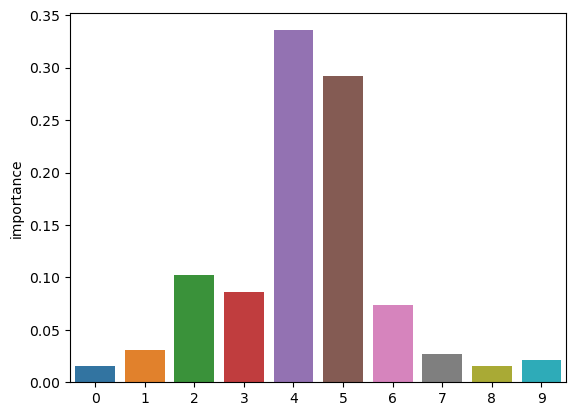

In [21]:
sns.barplot(feature_importances_table, x = feature_importances_table.index, y = 'importance')

As seen from the chart, feature #4 (`median_income`) has the highest importance.

# Question 6

Creating feature matrices for XGBoost model:

In [29]:
features = dv.get_feature_names_out()
features = [i.replace("=<", "_").replace("=","_") for i in features]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Defining the parameters for model A with `eta=0.3`:

In [45]:
xgb_params_A = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

Defining a watch list for model training process:

In [31]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

Defining a function for parsing the model training output:

In [40]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

Training model A and capturing its output in the process:

In [50]:
%%capture output

model_A = xgb.train(xgb_params_A, dtrain, num_boost_round=100, evals=watchlist)
df_rmse_model_A = parse_xgb_output(output)

Displaying model A training output:

In [48]:
df_rmse_model_A

,num_iter,train_rmse,val_rmse
0,0,0.44350,0.44250
1,1,0.36599,0.36916
2,2,0.31556,0.32382
3,3,0.28541,0.29965
4,4,0.26573,0.28417
...,...,...,...
95,95,0.11211,0.22908
96,96,0.11139,0.22875
97,97,0.11089,0.22864
98,98,0.11041,0.22868


Defining the parameters for model B with the same values as model A except `eta=0.1`:

In [49]:
xgb_params_B = xgb_params_A.copy()
xgb_params_B['eta'] = 0.1

Training model B and capturing its output in the process:

In [56]:
%%capture output

model_B = xgb.train(xgb_params_B, dtrain, num_boost_round=100, evals=watchlist)
df_rmse_model_B = parse_xgb_output(output)

Displaying model B training output:

In [57]:
df_rmse_model_B

,num_iter,train_rmse,val_rmse
0,0,0.52449,0.52045
1,1,0.48736,0.48443
2,2,0.45433,0.45293
3,3,0.42533,0.42550
4,4,0.39987,0.40144
...,...,...,...
95,95,0.16562,0.23276
96,96,0.16524,0.23266
97,97,0.16444,0.23246
98,98,0.16383,0.23222


Plotting the RMSE on the validation dataset for both models:

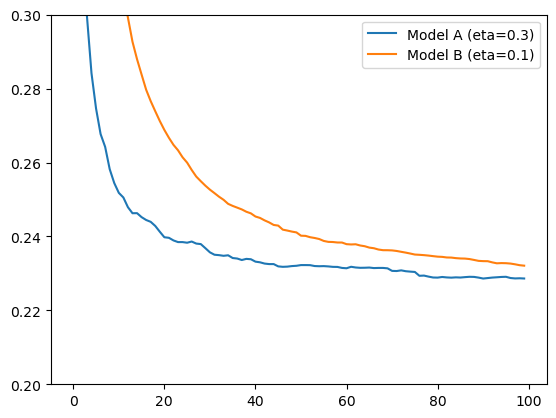

In [61]:
plt.plot(df_rmse_model_A['num_iter'], df_rmse_model_A['val_rmse'], label='Model A (eta=0.3)')
plt.plot(df_rmse_model_B['num_iter'], df_rmse_model_B['val_rmse'], label='Model B (eta=0.1)')
plt.ylim(0.2, 0.3)
plt.legend()
plt.show()

As seen from the above plot, model A with `eta=0.3` exhibits a better RMSE.